# Obtaining an object mask using the GrabCut algorithm

There are cases where we want to separate an object from other parts of a scene; in other words, where we want to create masks for the foreground and background. This job is tackled by the GrabCut algorithm. It can build object masks in semi-automatic mode. All that it needs are initial assumptions about object location. Based on these assumptions, the algorithm performs a multi-step iterative procedure to model statistical distributions of foreground and background pixels and find the best division according to the distributions. This sounds complicated, but the usage is very simple. Let's find out how easily we can apply this sophisticated algorithm in OpenCV .

OpenCV's `cv2.grabCut` implements the GrabCut algorithm. This function is able to work in several modes, and takes the following arguments: input 3channel image, a matrix with initial labels for pixels, a rectangle in (`x, y, w, h`) format to define label initialization, two matrices to store the process state, a number of iterations, and the mode in which we want the function to launch.

The function returns labels matrix and two matrices with the state of the process. The labels matrix is single-channel, and it stores one of these values in each pixel: `cv2.GC_BGD` (this means that the pixel definitely belongs to the background), `cv2.GC_PR_BGD` (this means that the pixel is probably in the background), `cv2.GC_PR_FGD` (for pixels which are possibly foreground), `cv2.GC_FGD` (for pixels which are definitely foreground). The two state matrices are necessary if we want to continue the process for a few iterations.

There are three possible modes for the function: `cv2.GC_INIT_WITH_RECT`, `cv2.GC_INIT_WITH_MASK` and `cv2.GC_EVAL`. The first one is used when we want to define labels initialization by the rectangle in the third argument. In this case, pixels outside of the rectangle are set to the `cv2.GC_BGD` value, and ones inside the rectangle are set to the `cv2.GC_PR_FGD` value.

The second mode of the function, `cv2.GC_INIT_WITH_MASK`, is used when we want to use the values of the second argument matrix as initialization for labels. In this case, the values should be set to one of four values: `cv2.GC_BGD`, `cv2.GC_PR_BGD`, `cv2.GC_PR_FGD`, `cv2.GC_FGD`.

The third mode, `cv2.GC_EVAL`, is for calling the function for another number of iterations, with the same state.

In the code, we darken the background to visualize the object mask. It works well when the object we want to segment has similar brightness to other parts of the image. But, in the case of a dark object on a bright scene, it won't work. So, you may need to apply another visualization technique in your own project.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S04\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s04\env

d:\html_doc\program\opencv\packt\s04\env\lib\site-packages
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s04\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


------  ../data/Lena.png---------    Shape(512, 512, 3) Lena: uint8
[ [ 96  88 196] [109  98 194] [138 121 198] [134 118 196] [105 100 193] [105  99 194] [132 117 188] ]
[ [130 121 194] [167 157 200] [158 165 207] [122 133 206] [127 118 200] [169 152 200] [173 168 205] ]
------  image_copy = np.copy(image)    Shape(512, 512, 3) image_copy: uint8
[ [ 96  88 196] [109  98 194] [138 121 198] [134 118 196] [105 100 193] [105  99 194] [132 117 188] ]
[ [130 121 194] [167 157 200] [158 165 207] [122 133 206] [127 118 200] [169 152 200] [173 168 205] ]


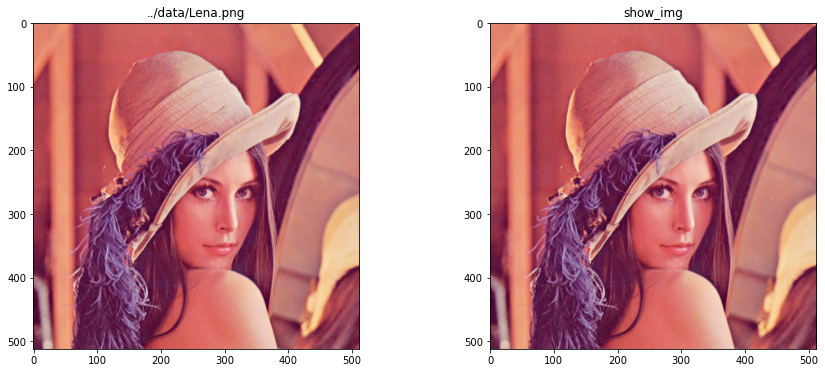

In [2]:
# Open an image and make a copy of it
image = cv2.imread('../data/Lena.png', cv2.IMREAD_COLOR)
image_copy = np.copy(image)


###################################################################
print_image('../data/Lena.png','Lena',image,44,46,221,228)
print_image('image_copy = np.copy(image)','image_copy',image,44,46,221,228)
plt_view_image(plt,[["../data/Lena.png",image[:,:,[2,1,0]] ],
                    ["show_img",image[:,:,[2,1,0]]   ]],
               figsize=(15,6), axis='on', cmap='gray'
              )

cv2.imshow('image, image_copy', np.hstack([image, image_copy]))
cv2.waitKey()
cv2.destroyAllWindows()

In [3]:
# Define some constants
mouse_pressed = False
y = x = w = h = 0

# Define the mouse callback function to draw a rectangle on the image
def mouse_callback(event, _x, _y, flags, param):
    global image_copy, x, y, w, h, mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x, y = _x, _y
        image_copy = np.copy(image)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            image_copy = np.copy(image)
            cv2.rectangle(image_copy, (x, y), (_x, _y), (0, 255, 0), 3)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x, _y - y
        
# Display the image
cv2.namedWindow('image select area. Press "a" when done')
cv2.setMouseCallback('image select area. Press "a" when done', mouse_callback)

# after the rectangle has been completed 
# and the A button on the keyboard has been pressed, 
# We'll close the window 
while True:
    cv2.imshow('image select area. Press "a" when done', image_copy)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break

cv2.destroyAllWindows()

print("w ==",w, "h ==", h)

w == 382 h == 472


# Алгоритм сегментации GrabCut

[Обзор алгоритмов сегментации](https://habr.com/en/company/intel/blog/266347/)

Это интерактивный алгоритм выделения объекта, разрабатывался как более удобная альтернатива магнитному лассо (чтобы выделить объект, пользователю требовалось обвести его контур с помощью мыши). Для работы алгоритма достаточно заключить объект вместе с частью фона в прямоугольник (grab). Сегментирование объекта произойдет автоматически (cut).

Могут возникнуть сложности при сегментации, если внутри ограничивающего прямоугольника присутствуют цвета, которые встречаются в большом количестве не только в объекте, но и на фоне. В этом случае можно поставить дополнительные метки объекта (красная линия) и фона (синяя линия).

# [Режем котиков. Или реализация GrabCut в OpenCV](https://delirium-00.livejournal.com/6148.html)
Алгоритм GrabCut был разработан Владимиром Колмогоровым, Карстеном Ротером и Эндрю Блэйком и предназначен для выделения объекта из фона с минимальным участием человека. Этот алгоритм, в свою очередь, основывается на алгоритме к-средних для обучения модели цветов(цвет фона и объекта моделируется смесью гауссиан (обычно 5-8 компонент) и легендарном алгоритме GraphCuts для сегментации.



------  labels-------------------    Shape(512, 512) labels: uint8
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
------  ../data/Lena.png---------    Shape(512, 512, 3) Lena: uint8
[ [ 96  88 196] [109  98 194] [138 121 198] [134 118 196] [105 100 193] [105  99 194] [132 117 188] ]
[ [130 121 194] [167 157 200] [158 165 207] [122 133 206] [127 118 200] [169 152 200] [173 168 205] ]
------  image_grabCut = np.copy(image)    Shape(512, 512, 3) image_grabCut: uint8
[ [32 29 65] [36 32 64] [138 121 198] [134 118 196] [35 33 64] [35 33 64] [132 117 188] ]
[ [43 40 64] [167 157 200] [158 165 207] [122 133 206] [127 118 200] [169 152 200

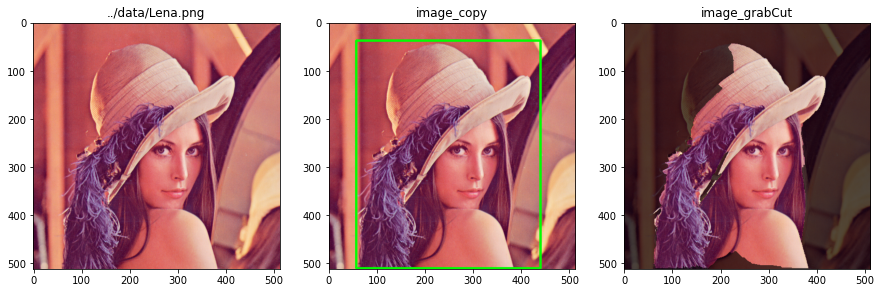

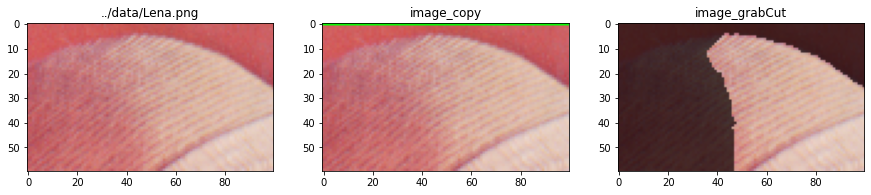

In [4]:
labels = np.zeros(image.shape[:2],np.uint8)

# cv2.grabCut() to create an object mask based on the rectangle
#Interactive Foreground Extraction using GrabCut Algorithm
#cv.grabCut (image, mask, rect, bgdModel, fgdModel, iterCount, mode = cv.GC_EVAL)
#  image - input 8-bit 3-channel image.
#  mask - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. 
#         It is done by the following flags, cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.
#         input/output 8-bit single-channel mask. The mask is initialized by the function when mode is set to 
#         GC_INIT_WITH_RECT. Its elements may have one of the cv.rabCutClasses.
# rect - ROI containing a segmented object. The pixels outside of the ROI are marked as "obvious background". The parameter is only 
#        used when mode==GC_INIT_WITH_RECT. It is the coordinates of a rectangle which 
#        includes the foreground object in the format (x,y,w,h)
# bgdModel - temporary array for the background model. Do not modify it while you are processing the same image.
#            These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).
# fgdModel - temporary arrays for the foreground model. Do not modify it while you are processing the same image.
#            These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).
# iterCount - number of iterations the algorithm should make before returning the result. Note that the result can be 
#             refined with further calls with mode==GC_INIT_WITH_MASK or mode==GC_EVAL .
# mode - operation mode that could be one of the cv::GrabCutModes. It should be cv.GC_INIT_WITH_RECT or cv.GC_INIT_WITH_MASK or 
#        combined which decides whether we are drawing rectangle or final touchup strokes.

labels, bgdModel, fgdModel = cv2.grabCut(image, labels, (x, y, w, h), 
                                         None, None, 5, 
                                         cv2.GC_INIT_WITH_RECT)
image_grabCut = np.copy(image)

# Give background region a darker shade
image_grabCut[(labels == cv2.GC_PR_BGD)|(labels == cv2.GC_BGD)] //= 3

###################################################
print_image('labels','labels',labels,44,46,180,280)
print_image('../data/Lena.png','Lena',image,44,46,221,228)
print_image('image_grabCut = np.copy(image)','image_grabCut',image_grabCut,44,46,221,228)
plt_view_image(plt,[["../data/Lena.png",image[:,:,[2,1,0]] ],
                    ["image_copy",image_copy[:,:,[2,1,0]]],
                    ["image_grabCut",image_grabCut[:,:,[2,1,0]]]],
               figsize=(15,6), axis='on', cmap='gray' 
              )
plt_view_image(plt,[["../data/Lena.png",image[40:100,180:280,[2,1,0]] ],
                    ["image_copy",image_copy[40:100,180:280,[2,1,0]]],
                    ["image_grabCut",image_grabCut[40:100,180:280,[2,1,0]]]],
               figsize=(15,6), axis='on', cmap='gray' 
              )
cv2.imshow('image, image_copy, image_grabCut', 
           np.hstack([image, image_copy, image_grabCut]))
cv2.waitKey()
cv2.destroyAllWindows()

In [5]:
# Define the mouse callback to draw the mask on the image
# It's necessary to repair mistakes in the previous cv2.grabCut call

label = cv2.GC_FGD
lbl_clrs = {cv2.GC_BGD: (0,0,0), cv2.GC_FGD: (255,255,255)}

def mouse_callback(event, x, y, flags, param):
    global mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        cv2.circle(labels, (x, y), 5, label, cv2.FILLED)
        cv2.circle(image_grabCut, (x, y), 5, lbl_clrs[label], cv2.FILLED)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            cv2.circle(labels, (x, y), 5, label, cv2.FILLED)
            cv2.circle(image_grabCut, (x, y), 5, lbl_clrs[label], cv2.FILLED)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        
cv2.namedWindow('fix skiped area. Press \n"a" == Exit\n"l" == Label background')
cv2.setMouseCallback('fix skiped area. Press \n"a" == Exit\n"l" == Label background',mouse_callback)

while True:
    cv2.imshow('fix skiped area. Press \n"a" == Exit\n"l" == Label background',image_grabCut)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        break
    elif k == ord('l'):
        label = cv2.GC_FGD - label

cv2.destroyAllWindows()

------  labels-------------------    Shape(512, 512) labels: uint8
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 ]
[ 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

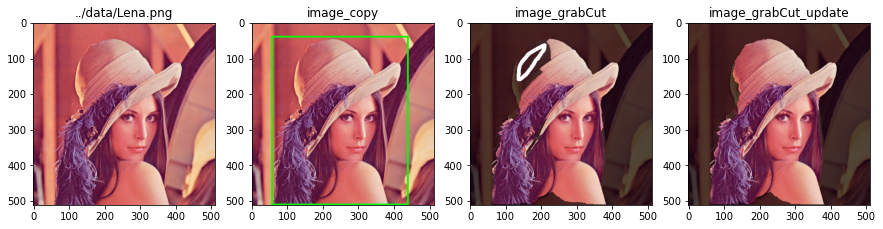

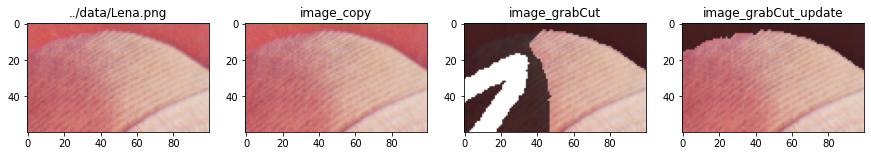

In [6]:
# Then, call cv2.grabCut again to get the fixed mask. 
labels, bgdModel, fgdModel = cv2.grabCut(image, labels, 
                                         None, bgdModel, fgdModel, 
                                         5, cv2.GC_INIT_WITH_MASK)


# Finally, update the mask on the image, and show it
image_grabCut_update = np.copy(image)
image_grabCut_update[(labels == cv2.GC_PR_BGD)|(labels == cv2.GC_BGD)] //= 3


####################################################
print_image('labels','labels',labels,45,50,180,280)
print_image('../data/Lena.png','Lena',image,45,50,218,225)
print_image('image_grabCut = np.copy(img)','image_grabCut',image_grabCut,45,50,218,225)
print_image('image_grabCut_update[(labels == cv2.GC_PR_BGD)|(labels == cv2.GC_BGD)] //= 3',
            'image_grabCut_update', image_grabCut_update,45,50,218,225)
plt_view_image(plt,[["../data/Lena.png",image[:,:,[2,1,0]] ],
                    ["image_copy",image_copy[:,:,[2,1,0]]],
                    ["image_grabCut",image_grabCut[:,:,[2,1,0]]],
                    ["image_grabCut_update",image_grabCut_update[:,:,[2,1,0]]] ],
               figsize=(15,6), axis='on', cmap='gray' 
              )
plt_view_image(plt,[["../data/Lena.png",image[40:100,180:280,[2,1,0]] ],
                    ["image_copy",image_copy[40:100,180:280,[2,1,0]]],
                    ["image_grabCut",image_grabCut[40:100,180:280,[2,1,0]]],
                    ["image_grabCut_update",image_grabCut_update[40:100,180:280,[2,1,0]]] ],
               figsize=(15,6), axis='on', cmap='gray' 
              )


cv2.imshow('img, img_grabCut', np.hstack([image_copy, image_grabCut,image_grabCut_update]))
cv2.waitKey()
cv2.destroyAllWindows()